In this notebook, we consider an information theoretic clustering function proposed by Principe et al. for image processing and combine it with some search heuristic for graph clustering.

An Information Theoretic Clustering Evaluation Function
--------------------------------------------------------
Given two distributions $p(x)$ and $q(x)$, and $N$ $n$-dimensional samples ${\bf x}_i$, $i=1,\ldots,N$, we are looking for a clustering of the $N$ points into two clusters, one corresponding to $p(x)$, and one to $q(x)$. 
The following clustering evaluation function, proposed by J. Principe and his coauthors, is considered:
$$
\frac{1}{N_1N_2}\sum_{i=1}^{N_1}\sum_{j=1}^{N_2}\frac{1}{(2\pi)^{n/2}(2\sigma^2)^{n/2}}\exp\left(-\frac{1}{2}({\bf x}_i-{\bf x}_j)^T \frac{1}{2\sigma^2}({\bf x}_i-{\bf x}_j) \right)
$$
where each sum is done over one cluster, thus one cluster containing $N_1$ samples, and the other $N_2$, with $N_1+N_2=N$. The minimum of this clustering evaluation function over all possible clusterings gives an allocation of each point to its distribution.  

We define a function that performs a within graph cluster evaluation using the above information theoretic function.

In [16]:
import time
import random
import numpy as np
import networkx as nx
import pylab as plt

def GGraphwithin(G,sigma2,start_clusters,verbose):
    #take a networkx directed graph as input, and sigma2 (which means sigma**2) is the bandwidth parameter 
    #orig_nb is the originial number of clusters before agglomeration
    
    #no of vertices 
    N = G.order()
    dist = np.zeros((N,N))
    
    #modified Jaccard distance
    for u in G.nodes():
        neighbu = list(G.neighbors(u))
        #if node has a zero out-degree, then it has distance "infinity"
        if len(neighbu) == 0:
            dist[u,:] = 1
        else: 
            for v in G.nodes():
                if not(v == u):
                    neighbv = list(G.neighbors(v))
                    DJuv = 1-len(set(neighbu).intersection(set(neighbv)))/len(set(neighbu).union(set(neighbv)))
                    neighbuall = neighbu + [u]
                    neighbvall = neighbv + [v]
                    DJuvall = 1-len(set(neighbuall).intersection(set(neighbvall)))/len(set(neighbuall).union(set(neighbvall)))
                    dist[u,v] = (DJuv + DJuvall)/2  
        dist[u,u] = 0
        
    #the input is one-dimensional
    n=1
    
    def EF(cur_label,new_members):
        #cur_label contains the current cluster
        #new_members is the list of nodes to choose a new cluster member from 
        N2 = len(cur_label)
        N1 = len(new_members)
        #initialization of the evaluation function
        Geval = 0
        Gevalmin = 1000
        new_member = 0
        #choose a new member
        for k1 in range(N1):
            #compute its distance with all members of the current cluster
            for k2 in range(N2):
                #some of the terms which do not influence the minimum have been ignored in the evaluation function
                x = dist[new_members[k1],cur_label[k2]]
                Geval = Geval + np.exp((-1/2)*(x*((1/(2*sigma2))*x))*(1/((2*sigma2)**(n/2))))
            Geval = Geval/(N2+1)                           
            #choose as new member the neighbour with the lowest Geval
            valid = (evaluated_ef[new_members[k1]]==0 or evaluated_ef[new_members[k1]]>Geval)
            if Geval < Gevalmin and valid:
                Gevalmin = Geval
                new_member = new_members[k1]
        evaluated_ef[new_member] = Gevalmin
        return new_member
    
    #initial labelling
    label = np.zeros(N)
    #pick some nodes at random forming the original singleton clusters
    #nb of clusters
    if type(start_clusters) == int:
        evaluated = random.sample(range(N),start_clusters)
        nb_orig = start_clusters
    else:
        evaluated = start_clusters
        nb_orig = len(start_clusters)
    evaluated_ef = np.zeros(N)
    if verbose == True:
        print('initial singleton clusters', evaluated)
    #assign them each to their own clusters
    for i in range(len(evaluated)):
        label[evaluated[i]] = i+1 
        
    #tic
    t = time.time()
    Gundirected = G.to_undirected()
    while np.count_nonzero(label) < N: #and all_leaves == False:
        all_leaves = True
        for l in range(nb_orig):
            #find all points belonging to cluster l
            cl = np.where((label - (l+1)*np.ones(N)) == 0)[0]
            list_neighbours = []
            list_allneighbours = []
            for node in cl:
                list_neighbours.extend([neighb for neighb in list(Gundirected[node]) if label[neighb] == 0])
                list_allneighbours.extend([neighb for neighb in list(Gundirected[node])])
            if len(list_neighbours) > 0:
                new_member_l = EF(cl,list_neighbours)
                label[new_member_l] = l+1   
            
    #toc 
    elapsed = time.time() - t
    if verbose == True:
        print('time in secs:',elapsed)
        print('no of clusters:',nb_orig)
    
    return list(label)

This plots the graph clustering.

In [8]:
def plot_cluster(G,labels,pos):
    #G is the graph, labels contains the clustering, 
    #pos is to use an existing graph layout
    
    val_map = {}
    for k in range(0,G.order()):
        val_map[k] = labels[k]

    values = [val_map.get(node, 0) for node in G.nodes()]

    #this fixes the size of the figure
    #plt.figure(1,figsize=(6,6)) 
    nx.draw(G, pos, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 200, with_labels=True)
    #nx.draw(G, pos, cmap=plt.get_cmap('rainbow'), node_color=values, node_size = 50)
    plt.show()

This creates a toy example.

In [9]:
G = nx.scale_free_graph(10)
pos = nx.spring_layout(G)
plot_cluster(G,[0 for x in G.nodes()],pos)

In [17]:
Glab = GGraphwithin(G,0.1,random.sample(range(G.order()),2),True)

initial singleton clusters [4, 8]
time in secs: 0.007456064224243164
no of clusters: 2


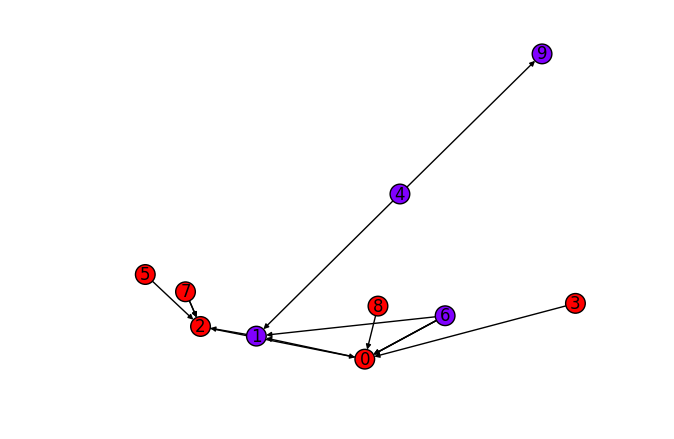

2


In [26]:
plot_cluster(G,Glab,pos)
print(len(set(Glab)))

In [9]:
Glab = GGraphwithin(G,0.1,random.sample(range(G.order()),1),True)

initial singleton clusters [4]
time in secs: 0.000293731689453125
no of clusters: 1


In [10]:
plot_cluster(G,Glab,pos)

Next we define a function that aggregates clusters.

In [14]:
def AggloClus(G,initial_label,verbose):
    #take as input a graph and an initial clustering
    
    N = G.order()
    dist = np.zeros((N,N))
    
    #modified Jaccard distance
    for u in G.nodes():
        #the code below works for u=v, only problem is if u=v has a zero out-degree
        dist[u,u] = 0
        neighbu = list(G.neighbors(u))
        #if node has a zero out-degree, then it has distance "infinity"
        if len(neighbu) == 0:
            dist[u,:] = N + 1
        else: 
            for v in G.nodes():
                if not(v == u):
                    neighbv = list(G.neighbors(v))
                    DJuv = 1-len(set(neighbu).intersection(set(neighbv)))/len(set(neighbu).union(set(neighbv)))
                    neighbuall = neighbu + [u]
                    neighbvall = neighbv + [v]
                    DJuvall = 1-len(set(neighbuall).intersection(set(neighbvall)))/len(set(neighbuall).union(set(neighbvall)))
                    dist[u,v] = (DJuv + DJuvall)/2  
    
    #the input is one-dimensional
    n=1
    
    def EF(clus1,clus2):
        #sigma
        sigma2 = 1
        #input, two existing clusters 
        N1 = len(clus1)
        N2 = len(clus2)
        #initialization of the evaluation function
        Geval = 0
        #computes the distance between the 2 clusters
        for k1 in range(N1):
            for k2 in range(N2):
                #some of the terms which do not influence the minimum have been ignored in the evaluation function
                x = dist[clus1[k1],clus2[k2]]
                Geval = Geval + np.exp((-1/2)*(x*((1/(2*sigma2))*x))*(1/((2*sigma2)**(n/2))))      
        return Geval/(N2*N1)  
    
    
    #nb of nodes
    N = len(list(initial_label))
    #node labelling
    label = np.zeros(N)
    #list and nb of clusters present
    list_clusters = list(set(initial_label))
    nb_clusters = len(list_clusters)

    #gather points in the same cluster   
    cl = []
    idl = []
    for l in list_clusters:
        #find all points belonging to cluster l
        cl.append(np.where((initial_label - l*np.ones(N)) == 0)[0])
        #idl just keeps track of where the cluster l is stored
        idl.append(l)
        
    #computes the distances among clusters
    dGeval = np.zeros((nb_clusters,nb_clusters))
    for l1 in range(nb_clusters):
        for l2 in range(l1+1,nb_clusters):
            dGeval[l1][l2] = EF(cl[l1],cl[l2])   
            dGeval[l2][l1] = dGeval[l1][l2] 
    
    #tic
    t = time.time()    
    while len(list_clusters) > 0:
        #pick an existing cluster at random
        curr_cluster = int(random.sample(list_clusters,1)[0])  
        for u in cl[idl.index(curr_cluster)]:
            label[u] = curr_cluster
        #remove the cluster 
        list_clusters.pop(list_clusters.index(curr_cluster))
        #look for the closest neighbour
        neighb_list = [list(dGeval[idl.index(curr_cluster)])[idl.index(u)] for u in list_clusters] 
        if len(neighb_list) > 0:
            neighb = int(list_clusters[neighb_list.index(max(neighb_list))])
            for u in cl[idl.index(neighb)]:
                label[u] = curr_cluster
            #remove the neighbour 
            list_clusters.pop(list_clusters.index(neighb))    

    #toc 
    elapsed = time.time() - t
    if verbose == True:
        print('time in secs:',elapsed)
        print('no of clusters:',len(set(label)))
    
    return list(label)

We define a function that combines both the above function to obtain a hierarchical clustering.

In [15]:
def HierClus(G,nb_iter,sigma2,start_clusters,verbose):
    #G is the graph
    #nb_iter is the number of times the agglomeration is done
    #orig_nb is the number of singleton clusters to start
    
    #computes an initial labelling
    initiallabel = GGraphwithin(G,0.01,start_clusters,verbose)
    
    #keeps track of all the labellings for plotting purpose
    all_labels = [[] for k in range(nb_iter)]
    all_labels[0] = initiallabel
    
    #repeat the agglomeration nb_iter times
    for k in range(1,nb_iter):
        all_labels[k] = AggloClus(G,all_labels[k-1],verbose)
    
    return all_labels

In [54]:
#https://stackoverflow.com/questions/12725263/computing-f-measure-for-clustering

def compute_pairs(labels):
    Lpairs = []
    clus_list = set(labels)
    for clus in clus_list: 
        s = [i for i, x in enumerate(labels) if x == clus]
        for i in range(len(s)):
            for j in range(i+1,len(s)):
                #[set(i) for i in itertools.combinations(s, 2)]
                Lpairs.extend([(s[i],s[j])])
    return Lpairs

In [21]:
def Fmeasure(labels,truthlabels):
    Pclus = set(compute_pairs(labels))
    Ptrue = set(compute_pairs(truthlabels))
    a = len(Pclus.intersection(Ptrue))
    b = len(Pclus-Ptrue)
    c = len(Ptrue-Pclus)
    F = (2*a)/(2*a+b+c)
    return F

The Montreal Gang Network
----

no of vertices 36


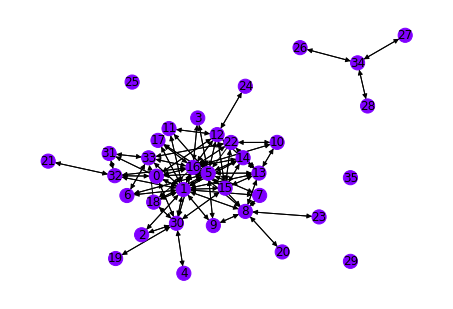

In [11]:
import networkx as nx
import pylab as plt

import csv
reader = csv.reader(open("MontrealCSV/MONTREALGANG.csv"), delimiter=",")
L = []
cnt_row = 0
for row in enumerate(reader):
    cnt_row = cnt_row + 1
    L.append(row[1][1:])
adjlist = [list(map(int,adj)) for adj in L[1:]]
E = [(i,j) for i in range(len(adjlist)) for j in range(len(adjlist)) if not(adjlist[i][j]==0)]

GMG=nx.DiGraph()
GMG.add_nodes_from(range(0,cnt_row))
#edges
GMG.add_edges_from(E)
print('no of vertices',GMG.order())

#computes the graph layout
posGMG = nx.nx_pydot.graphviz_layout(GMG)
#plots the graph
plot_cluster(GMG,[0 for x in GMG.nodes()],posGMG)

In [12]:
GMGlab = GGraphwithin(GMG,0.1,random.sample(range(G.order()),5),True)

initial singleton clusters [6, 3, 7, 2, 9]
time in secs: 0.0032112598419189453
no of clusters: 5


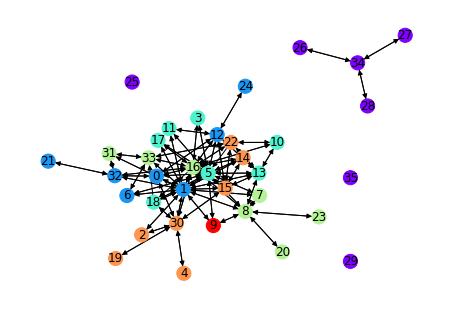

In [13]:
plot_cluster(GMG,GMGlab,posGMG)

In [16]:
GMGalllabels = HierClus(GMG,3,0.01,random.sample(range(GMG.order()),5),True)

initial singleton clusters [28, 22, 2, 29, 30]
time in secs: 0.004473209381103516
no of clusters: 5
time in secs: 0.0003139972686767578
no of clusters: 3
time in secs: 5.078315734863281e-05
no of clusters: 2


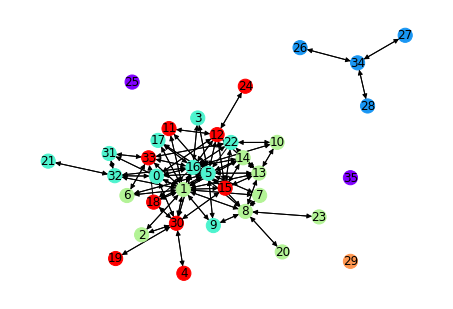

In [17]:
from networkx.drawing.nx_agraph import graphviz_layout

#fig = plt.figure(figsize=(15,25))
#fig = plt.figure()

#*********first subplot
#plt.subplot(3, 1, 1)
plot_cluster(GMG,GMGalllabels[0],posGMG)

In [18]:
#*********second subplot
#plt.subplot(3, 1, 2)
plot_cluster(GMG,GMGalllabels[1],posGMG)

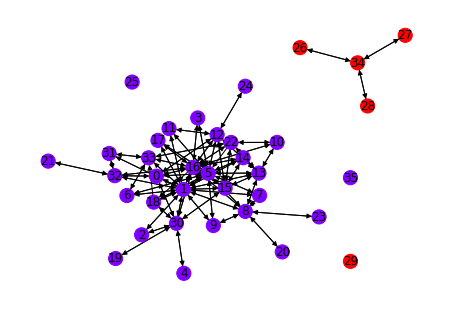

In [19]:
#*********third subplot
#plt.subplot(3, 1, 3)
plot_cluster(GMG,GMGalllabels[2],posGMG)

The EU email network
--

In [42]:
Geu = nx.read_edgelist('email-Eu-core.txt', nodetype=int, create_using= nx.DiGraph())
print(Geu.order())
Geu.size()

1005


25571

In [44]:
#posGeu = nx.nx_pydot.graphviz_layout(Geu)
poseGeu = nx.spring_layout(Geu)

In [45]:
plot_cluster(Geu,[0 for x in Geu.nodes()],posGeu)

In [46]:
import csv
 
EU_gt = []
with open('email-Eu-core-department-labels.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=' ')
    line_count = 0
    for row in csv_reader:
        EU_gt.append(int(row[1]))
        line_count += 1
len(set(EU_gt))

42

In [63]:
Geualllabels = HierClus(Geu,5,0.01,random.sample(range(Geu.order()),630),True)

initial singleton clusters [7, 881, 321, 463, 807, 234, 823, 932, 535, 941, 201, 394, 699, 566, 184, 2, 291, 226, 993, 711, 105, 113, 853, 385, 738, 248, 117, 645, 501, 625, 721, 11, 714, 264, 198, 249, 657, 214, 782, 191, 480, 498, 863, 235, 320, 679, 364, 848, 666, 93, 560, 821, 317, 781, 799, 185, 589, 784, 465, 211, 916, 195, 885, 175, 808, 472, 662, 772, 152, 551, 802, 94, 545, 873, 731, 405, 720, 445, 740, 691, 911, 695, 996, 145, 616, 646, 934, 91, 700, 439, 397, 830, 38, 749, 289, 335, 389, 735, 265, 955, 255, 374, 686, 516, 159, 777, 434, 958, 999, 300, 569, 913, 477, 570, 582, 658, 496, 929, 294, 709, 258, 342, 819, 295, 715, 48, 567, 930, 108, 549, 209, 123, 227, 813, 313, 547, 357, 837, 683, 599, 481, 659, 614, 744, 453, 788, 69, 767, 952, 947, 574, 964, 816, 153, 71, 478, 633, 886, 304, 65, 779, 1000, 991, 361, 417, 247, 624, 194, 527, 852, 595, 354, 912, 775, 5, 488, 188, 506, 712, 269, 703, 6, 602, 540, 416, 275, 326, 872, 272, 951, 238, 432, 615, 942, 785, 780, 861, 116

In [64]:
Fmeasure(Geualllabels[3],EU_gt)

0.10685069853560007

In [ ]:
fbest = 0.12
fcurr = 0
while fcurr < fbest:
    Geualllabels = HierClus(Geu,4,0.01,random.sample(range(Geu.order()),320),False)
    fcurr = Fmeasure(Geualllabels[3],EU_gt)
    print(fcurr)